In [1]:
# #!pip install tf-nightly==2.5.0.dev20201111 -qqq --progress-bar off
# import tensorflow as tf
# print(tf.__version__)
# assert tf.__version__== '2.5.0-dev20201111','bad version'

In [2]:
cd /Users/aidasaglinskas/Desktop/BC-MRI-AE/Colab Notebooks

/Users/aidasaglinskas/Desktop/BC-MRI-AE/Colab Notebooks


In [3]:
%matplotlib inline
from datetime import datetime;now = datetime.now;t00 = now()
import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.mixture import BayesianGaussianMixture

#from contrastive_vae.celeb_utils import get_celeb_vae
#from contrastive_vae.celeb_utils import get_celeb_cvae

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import pandas as pd
from sklearn.metrics import silhouette_score

from mri_utils import get_MRI_CVAE_3D,get_MRI_CCVAE_3D

from sklearn.decomposition import PCA
import umap

print(now()-t00)

0:00:05.791695


In [4]:
cd ../

/Users/aidasaglinskas/Desktop/BC-MRI-AE


In [5]:
def getCaseMatch(dx_idx,do_plot=False,control='non-familial-control'):
    ''' takes in IDs of ASD subjects, gives back IDs of TDs matched on age and gender'''
    ii = list()
    dfsc = dfs.copy();
    for dx_ind in range(sum(dx_idx)):
        dfsc = dfsc.set_index(np.arange(len(dfsc)))
        dx_age = dfsc['age_years'].values[dx_idx]
        dx_sex = dfsc['sex'].values[dx_idx]
        idxs = np.arange(len(dfs))
        v1 = dfsc['family_type'].values==control
        v2 = dfsc['sex'].values == dx_sex[dx_ind]
        v_dx = dfsc['clinical_asd_dx'].values !='1'
        
        v3 = abs(dfsc['age_years'].values[v1*v2*v_dx]-dx_age[dx_ind])

        match_arr = idxs[v1*v2][np.argsort(v3)]
        match_arr = np.array(match_arr)
        match_arr = match_arr[np.array([m not in ii for m in match_arr])]
        i = match_arr[0]
        ii.append(i)

    caseMatch_idx = ii
    caseMatch_idx.sort()
    caseMatch_idx
    assert len(caseMatch_idx)==len(np.unique(caseMatch_idx)),'non unique elements'
    if do_plot==True:
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.hist(dfs['sex'].values[caseMatch_idx],alpha=.3)
        plt.hist(dfs['sex'].values[dx_idx],alpha=.3)

        plt.subplot(1,3,2)
        plt.hist(dfs['age_years'].values[caseMatch_idx],alpha=.3)
        plt.hist(dfs['age_years'].values[dx_idx],alpha=.3)

        plt.subplot(1,3,3)
        plt.hist(dfs['family_type'].values[caseMatch_idx],alpha=.3)
        plt.hist(dfs['family_type'].values[dx_idx],alpha=.3)
        
    return caseMatch_idx

In [6]:
# get abide dataframe
arr = np.load('./Data/ABIDE-Anat-64iso.npz')
ABIDE_data = arr['data']
ABIDE_subs = arr['subs']
nsubs = ABIDE_data.shape[0]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

aa = np.array([ABIDE_data[s,:,:,:].sum() for s in range(ABIDE_data.shape[0])])<5000
ABIDE_data = ABIDE_data[~aa,:,:,:]
ABIDE_subs = ABIDE_subs[~aa]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

df = pd.read_csv('./CSVs/ABIDE-legend.csv',header=0)
df = df.iloc[np.array([df['BIDS_ID'].values[s] in ABIDE_subs for s in range(len(df))])]
df.reset_index(inplace=True)

assert len(df)==len(ABIDE_subs),'dif lenghts'
assert all([df['BIDS_ID'][s]==ABIDE_subs[s] for s in range(len(df))]),'mismatch between df and goodsubs'

df.head(5)

,index,BIDS_ID,Anonymized ID,Subject Type,Visit,Days since enrollment,SubID,DxGroup,DSMIVTR,AgeAtScan,...,WISC4 Pic Con Scaled,WISC4 Matrix Scaled,WISC4 Dig Span Scaled,WISC4 Let Num Scaled,WISC4 Coding Scaled,WISC4 Sym Scaled,Age at MPRAGE,Current Med Status,Medication Name,Off stimulants at EPI scan?
0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,2,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,2,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,2,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [7]:
TD_subs = ABIDE_data[np.array(df['Subject Type']=='CONTROL'),:,:,:]
DX_subs = ABIDE_data[np.array(df['Subject Type']=='PATIENT'),:,:,:]

print(TD_subs.shape)
print(DX_subs.shape)

(500, 64, 64, 64)
(456, 64, 64, 64)


In [8]:
dxArr = np.ones(len(df))
dxArr[np.array(df['Subject Type']=='PATIENT')]=2

In [9]:
# get convolutional vae (CVAE)
encoder, decoder, vae = get_MRI_CVAE_3D(input_shape=(64, 64, 64, 1), latent_dim=2, batch_size=32, disentangle=False, gamma=1)#
vae.load_weights('../tf_outputs/weights/lol');

In [274]:
# get contrastive convolutional vae (CCVAE)
cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(input_shape=(64, 64, 64, 1),latent_dim=16)
#weights_fn = '../tf_outputs/3D_CCVAE_Weights/lol'
weights_fn = '../tf_outputs/3D_CCVAE_Weights/Nov23'
cvae.load_weights(weights_fn)

Text(0.5, 1.0, 'CVAE prediction')

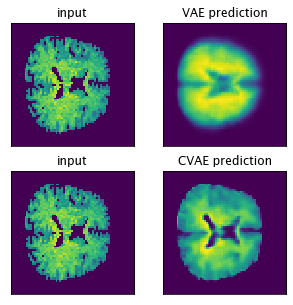

In [275]:
inMat = ABIDE_data[0:5,:,:,:]

plt.figure(figsize=(5,5))
plt.subplot(2,2,1);plt.imshow(ABIDE_data[0,:,:,40]);plt.xticks([]);plt.yticks([]);plt.title('input')
plt.subplot(2,2,2);plt.imshow(vae.predict(inMat)[0,:,:,40,0]);plt.xticks([]);plt.yticks([]);plt.title('VAE prediction')

plt.subplot(2,2,3);plt.imshow(ABIDE_data[0,:,:,40]);plt.xticks([]);plt.yticks([]);plt.title('input')
plt.subplot(2,2,4);plt.imshow(cvae.predict([inMat,inMat])[0][0,:,:,40,0]);plt.xticks([]);plt.yticks([]);plt.title('CVAE prediction')

In [276]:
def dim_reduce(z,method='PCA'):
    
    if method=='UMAP':
        reducer = umap.UMAP()
    else:
        reducer = PCA(n_components=2)
        
    tiny = reducer.fit_transform(z)
    #plt.plot(tiny[:,0],tiny[:,1],'r.')
    
    return tiny

In [277]:
def project_data(data,dxArr,lbls,legend=True):
    plt.figure(figsize=(12,4));
    plt.subplot(1,3,1);
    
    z_mean, z_log_var, z = z_encoder(data[:,:,:,:]);
    s_mean, s_log_var, s = s_encoder(data[:,:,:,:]);
    v_mean, v_log_var, v = encoder(data[:,:,:,:]);
    
    if z.shape[1]>2:
        print('reducing dimensionality')
        z = dim_reduce(z)
        s = dim_reduce(s)
        v = dim_reduce(v)
    
    x = z;x = np.array(x);
    mark = ['b.', 'g.', 'r.', 'c.', 'm.', 'y.', 'k.','b*', 'g*', 'r*', 'c*', 'm*', 'y*', 'k*','bx', 'gx', 'rx', 'cx', 'mx', 'yx', 'kx']
    for i in range(len(np.unique(dxArr))):
        ii = np.unique(dxArr)[i];
        plt.plot(x[dxArr==ii,0],x[dxArr==ii,1],mark[int(i)],markersize=15,alpha=.3);
        
    if legend:
        plt.legend(lbls);
    plt.title('CAE background');

    plt.subplot(1,3,2)
    x = s;
    x = np.array(x);

    for i in range(len(np.unique(dxArr))):
        ii = np.unique(dxArr)[i];
        plt.plot(x[dxArr==ii,0],x[dxArr==ii,1],mark[int(i)],markersize=15,alpha=.3);
    if legend:
        plt.legend(lbls);
    plt.title('CAE salient');

    plt.subplot(1,3,3);
    
    x = v;
    x = np.array(x);

    for i in range(len(np.unique(dxArr))):
        ii = np.unique(dxArr)[i];
        plt.plot(x[dxArr==ii,0],x[dxArr==ii,1],mark[int(i)],markersize=15,alpha=.3);
    if legend:
        plt.legend(lbls);
    plt.title('VAE');
    
    if len(np.unique(dxArr))>1:
        plt.figure(figsize=(6,4));
        plt.bar([0,1,2],[silhouette_score(z,dxArr),silhouette_score(s,dxArr),silhouette_score(v,dxArr)]);
        plt.xticks([0,1,2],labels=['CAE background','CAE salient','Vae']);
        plt.title('Silhouette score')
        plt.ylim(0,1)

# Laten Space Clusters

reducing dimensionality


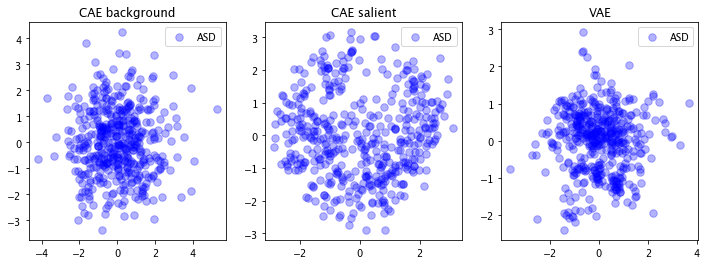

In [278]:
v = df['Subject Type'].values=='PATIENT'
data = ABIDE_data[v,:,:,:]; dxArr = np.ones(data.shape[0]); lbls = ['ASD']
project_data(data,dxArr,lbls)

reducing dimensionality


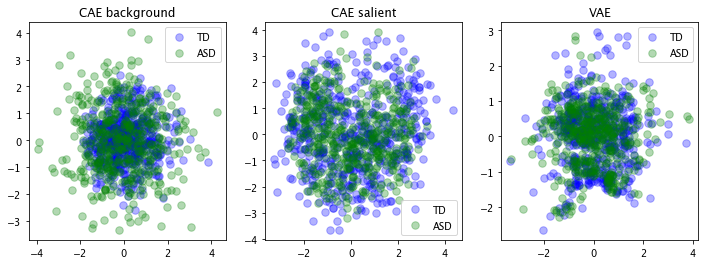

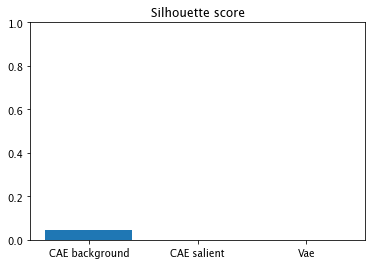

In [279]:
# TD and ASD subjects in different colours 
dxArr = np.ones(len(df))
dxArr[np.array(df['Subject Type']=='PATIENT')]=2

data = ABIDE_data;dxArr = dxArr;lbls = ['TD','ASD']
project_data(data,dxArr,lbls)

In [280]:
# encoders 
encs = [z_encoder, s_encoder ,encoder] # background, salient, vae

reducing dimensionality


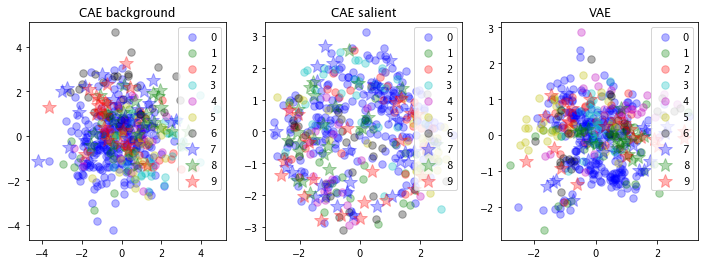

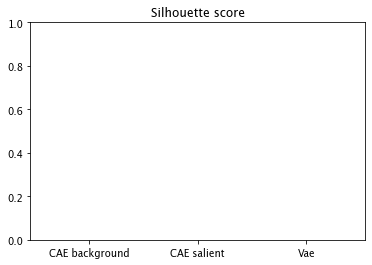

In [282]:
# Clustering defined on using 'background' features
v = df['Subject Type'].values=='PATIENT'
data = ABIDE_data[v,:,:,:]; dxArr = np.ones(data.shape[0]); lbls = ['ASD']

bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=10,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=1,weight_concentration_prior_type='dirichlet_process')
cid_s = bnpc.fit_predict(np.array(encs[0](data)[2]))

lbls = [str(u) for u in np.unique(cid_s)];
dxArr = cid_s
project_data(data,dxArr=cid_s,lbls=lbls)

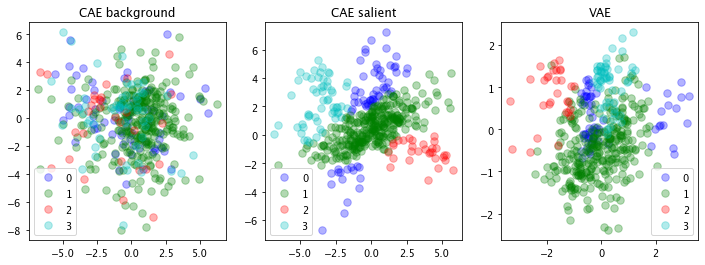

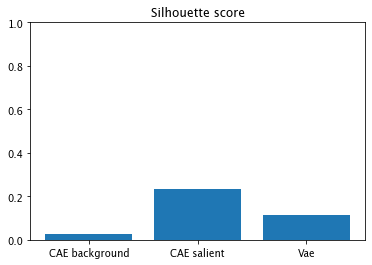

In [18]:
# Clustering defined on using 'salient' features
v = df['Subject Type'].values=='PATIENT'
data = ABIDE_data[v,:,:,:]; dxArr = np.ones(data.shape[0]); lbls = ['ASD']

bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=10,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid_s = bnpc.fit_predict(np.array(encs[1](data)[2]))

lbls = [str(u) for u in np.unique(cid_s)];
dxArr = cid_s
project_data(data,dxArr=cid_s,lbls=lbls)

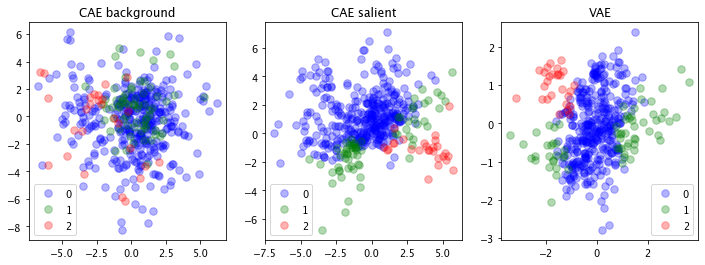

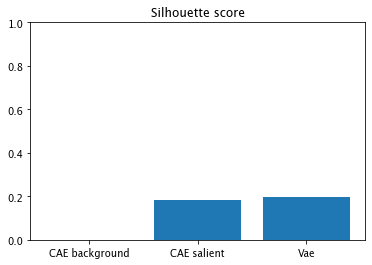

In [19]:
# Clustering defined on using vanilla VAE features

v = df['Subject Type'].values=='PATIENT'
data = ABIDE_data[v,:,:,:]; dxArr = np.ones(data.shape[0]); lbls = ['ASD']

bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=10,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid_s = bnpc.fit_predict(np.array(encs[2](data)[2]))

lbls = [str(u) for u in np.unique(cid_s)];
dxArr = cid_s
project_data(data,dxArr=cid_s,lbls=lbls)

## SFARI data 

In [20]:
arr = np.load('./Data/SFARI-Anat-64iso.npz')
SFARI_data = arr['data']
SFARI_subs = arr['subs']
snsubs = SFARI_data.shape[0]
print(arr.files)
SFARI_data.shape

['data', 'subs']


(131, 64, 64, 64)

In [21]:
#dfs = pd.read_csv('./CSVs/SFARI-legend.csv')
dfs = pd.read_csv('./CSVs/DS-use.csv')
dfs = dfs.iloc[np.array([l in SFARI_subs for l in dfs['BIDS ID'].values])]

In [22]:
assert all([dfs['BIDS ID'].values[i]==SFARI_subs[i] for i in range(snsubs)]),'badness'
assert len(dfs)==len(SFARI_subs),'bad coder, bad!'

In [23]:
# SLICE: Only Keep 16p and TD
ugene = ['non-familial-control','16p-duplication','16p-deletion']
slice_arr = np.array([val in ugene for val in dfs['family_type'].values])

dfs = dfs.iloc[slice_arr]
snsubs = len(dfs)
SFARI_data = SFARI_data[slice_arr,:,:,:]
SFARI_subs = SFARI_subs[slice_arr]
print(snsubs)

121


In [24]:
dfs.head()

,BIDS ID,SVIP ID,FCAP1,SCAP1,SCAP2,family_type,genetic_status_16p,svip_diagnosis_m1,ados_css,ados_module,...,relationship_to_iip,rrb_css,sa_css,sex,svip_neuro_exam.background.head_circum,svip_neuro_exam.background.head_circum_perc,svip_neuro_exam.background.head_circum_z_score,svip_neuro_exam.measure.eval_age_months,svip_neuro_exam.measure.measure_type,age_years
0,sub-004,14705.x14,14705.x14_50_FCAP1,14705.x14_40_SCAP1,[],16p-duplication,duplication,no-diagnosis,2,ados-4,...,Mother,1,2,female,[],[],[],405,svip-neuro-exam,34
1,sub-008,14708.x10,14708.x10_60_FCAP1,14708.x10_40_SCAP1,[],16p-deletion,deletion,non-spectrum-dx,2,ados-3,...,Initially identified proband,1,3,female,54.8,[],2.08,113,svip-neuro-exam,9
2,sub-012,14713.x7,14713.x7_50_FCAP1,14713.x7_30_SCAP1,[],16p-deletion,deletion,non-spectrum-dx,6,ados-3,...,Initially identified proband,5,7,male,55.2,[],2.28,87,svip-neuro-exam,7
3,sub-014,14714.x18,14714.x18_60_FCAP1,14714.x18_40_SCAP1,[],16p-deletion,deletion,no-diagnosis,2,ados-4,...,Initially identified proband,6,2,male,55.8,[],0.49,249,svip-neuro-exam,21
4,sub-018,14718.x5,14718.x5_50_FCAP1,14718.x5_20_SCAP1,[],16p-deletion,deletion,non-spectrum-dx,1,ados-3,...,Initially identified proband,1,1,female,54,[],1.15,127,svip-neuro-exam,11


In [25]:
geneVec = np.repeat(0,snsubs)
geneVec[dfs['family_type'].values==ugene[0]]=1
geneVec[dfs['family_type'].values==ugene[1]]=2
geneVec[dfs['family_type'].values==ugene[2]]=3

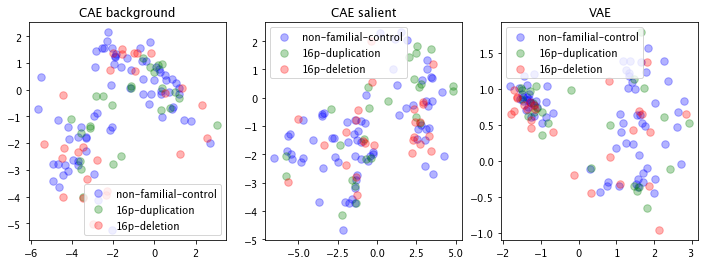

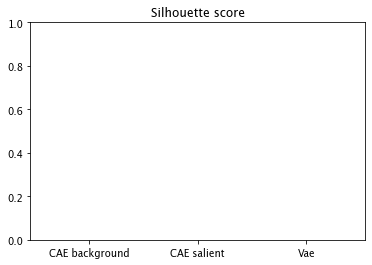

In [26]:
# SFARI data coloured by genotype,
data = SFARI_data
dxArr = geneVec
lbls = ugene
project_data(data,dxArr,lbls)

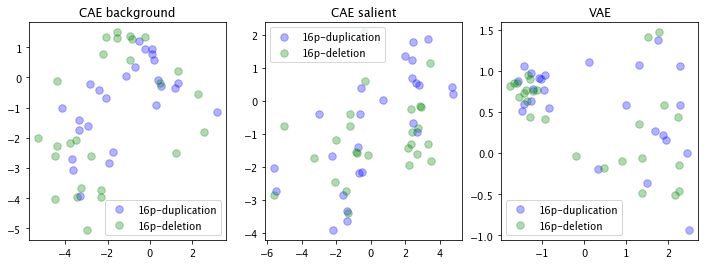

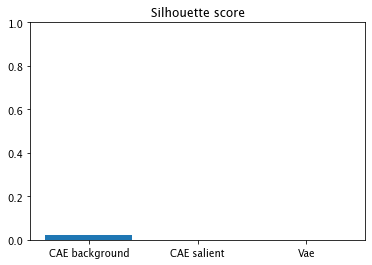

In [27]:
# only CNV carriers
d = np.array([val in [2,3] for val in geneVec])
data = SFARI_data[d,:,:,:]
dxArr = geneVec[d]
lbls = ugene[1::]
project_data(data,dxArr,lbls)

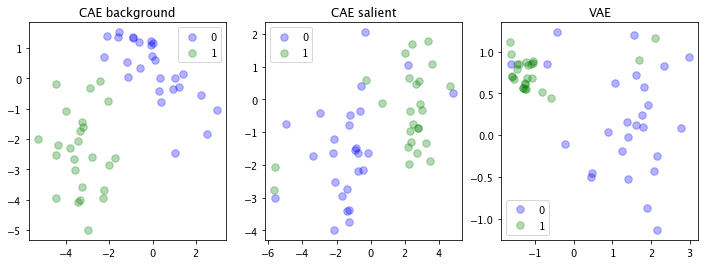

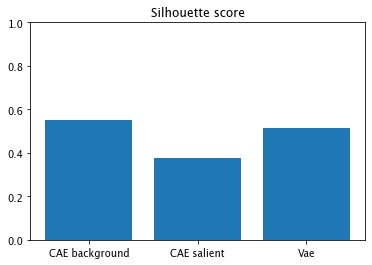

In [28]:
# Clustering based on background features
d = np.array([val in [2,3] for val in geneVec])
data = SFARI_data[d,:,:,:]
dxArr = geneVec[d]
lbls = ugene[1::]

bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=10,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid = bnpc.fit_predict(np.array(encs[0](data)[2]))

lbls = [str(u) for u in np.unique(cid)];
dxArr = cid
project_data(data,dxArr=cid,lbls=lbls)

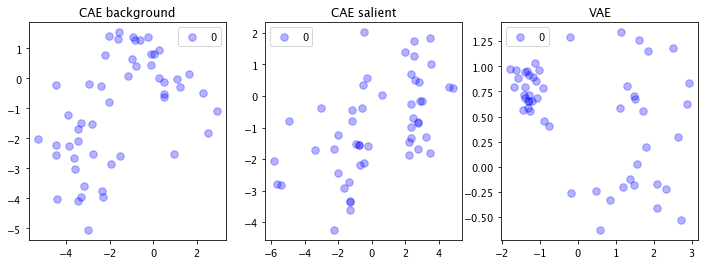

In [29]:
# Clustering based on salient features 

d = np.array([val in [2,3] for val in geneVec])
data = SFARI_data[d,:,:,:]
dxArr = geneVec[d]
lbls = ugene[1::]

bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=10,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid = bnpc.fit_predict(np.array(encs[1](data)[2]))

lbls = [str(u) for u in np.unique(cid)];
dxArr = cid
project_data(data,dxArr=cid,lbls=lbls)

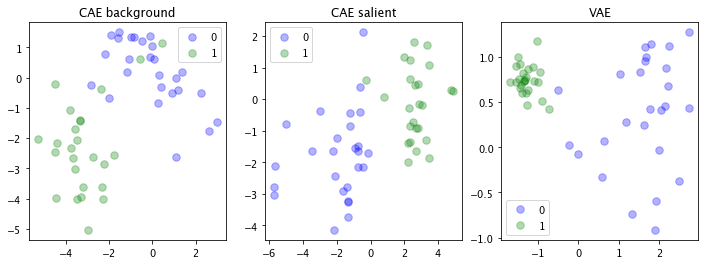

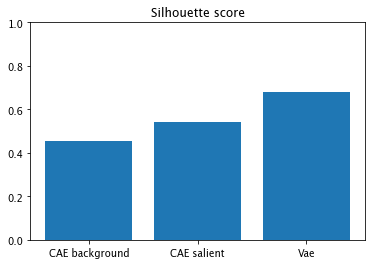

In [30]:
# Clustering based on VAE features 
d = np.array([val in [2,3] for val in geneVec])
data = SFARI_data[d,:,:,:]
dxArr = geneVec[d]
lbls = ugene[1::]

bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=10,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid = bnpc.fit_predict(np.array(encs[2](data)[2]))

lbls = [str(u) for u in np.unique(cid)];
dxArr = cid
project_data(data,dxArr=cid,lbls=lbls)

## SFARI (CASE-CONTROL MATCHED)

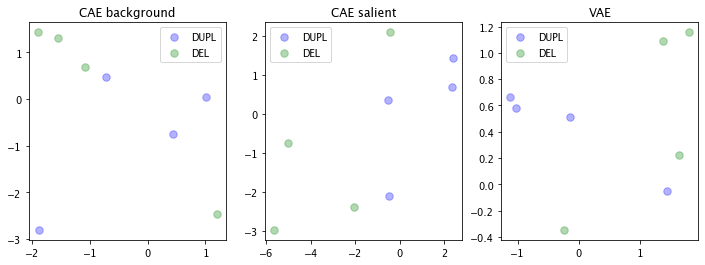

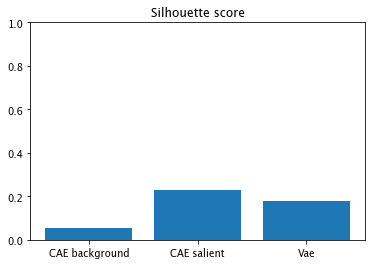

In [31]:
# Age and Gender matched del and dupl subjects
# Salient space seems to better differentiate them (only 4 subjects though)
#
#

dd = np.zeros(snsubs)
v1 = dfs['family_type'].values=='16p-duplication'
v2 = dfs['age_years'].values < 10
targ = v1*v2
ccidx = np.array(getCaseMatch(targ,do_plot=False,control='16p-deletion'))
dd[targ]=1;dd[np.array(ccidx)]=2;d = dd!=0
project_data(SFARI_data[d,:,:,:],dd[d],['DUPL','DEL'])

(0.0, 1)

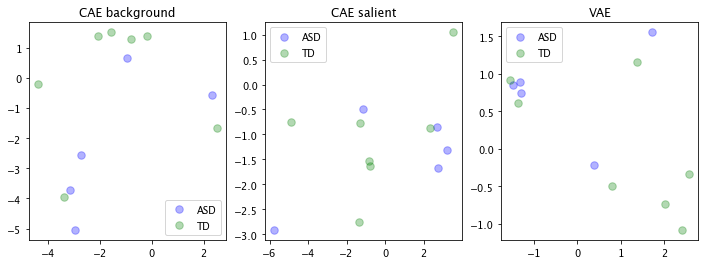

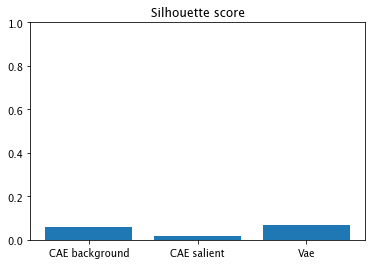

In [32]:
# Case matched ASD and TD subjects (all have 16p-deletion) 
# No clear differentiation

dd = np.zeros(snsubs)
v1 = dfs['clinical_asd_dx'].values=='1'
v2 = dfs['age_years'].values < 10
targ = v1
ccidx = np.array(getCaseMatch(targ,do_plot=False,control=ugene[2]))
dd[targ]=1;dd[np.array(ccidx)]=2;d = dd!=0
project_data(SFARI_data[d,:,:,:],dd[d],['ASD','TD']);plt.ylim(.0,1)
#print(dfs['family_type'].values[dfs['clinical_asd_dx'].values=='1'])

# ALTERNATIVE EXPLANATIONS of CLUSTERING

In [33]:
space_bg_abide = np.array(encs[0].predict(ABIDE_data)[2]) # background space
space_sl_abide = np.array(encs[1].predict(ABIDE_data)[2]) # salient space
space_vae_abide = np.array(encs[2].predict(ABIDE_data)[2])# vae space

In [34]:
if space_bg_abide.shape[1] > 2:
    space_bg_abide = dim_reduce(space_bg_abide)
    space_sl_abide = dim_reduce(space_sl_abide)
    space_sl_abide = dim_reduce(space_vae_abide)

In [35]:
patients = df['Subject Type'].values=='PATIENT'
controls = df['Subject Type'].values=='CONTROL'
all_subs = patients+controls

In [36]:
def plot_cscatter(dxArr,v=np.arange(len(df)),clbl=None,clim=None):
    space_lbls = ['background','salient','VAE']
    spaces = [space_bg_abide, space_sl_abide, space_vae_abide]
    sub_slices = [controls,patients,patients]
    
    plt.figure(figsize=(15,5))
    for i in range(3):
        plt.subplot(1,3,i+1)
        space = spaces[i]
        v = sub_slices[i]
        plt.scatter(space[v,0],space[v,1],c=dxArr[v])
        if clim:
            plt.clim(clim[0],clim[1])
        cbar = plt.colorbar()
        #cbar.ax.set_ylabel(clbl, rotation=270)
        cbar.ax.set_ylabel(clbl, rotation=270,labelpad=20,fontsize=16,fontweight='bold')
        plt.title(space_lbls[i],fontsize=16,fontweight='bold')

    plt.subplots_adjust(
        left=None,
        bottom=None,
        right=None,
        top=None,
        wspace=.3,
        hspace=None,)

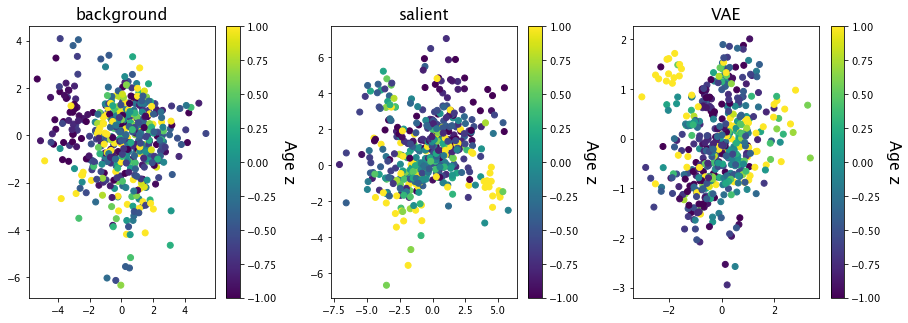

In [37]:
# Dots coloured by age (z scored)
ages = df['AgeAtScan'].values
agesz = (ages-ages.mean())/ages.std()
plot_cscatter(agesz,clbl='Age z',clim=(-1,1))

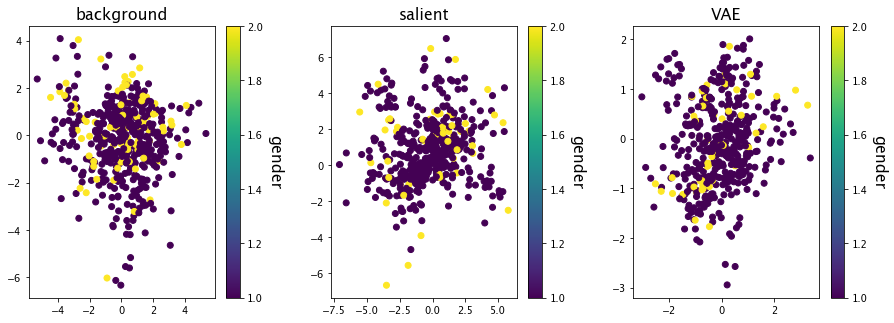

In [38]:
# Dots coloured by gender. 1=Male, 2=Female
gender = df['Sex'].values
plot_cscatter(gender,clbl='gender',clim=(1,2))

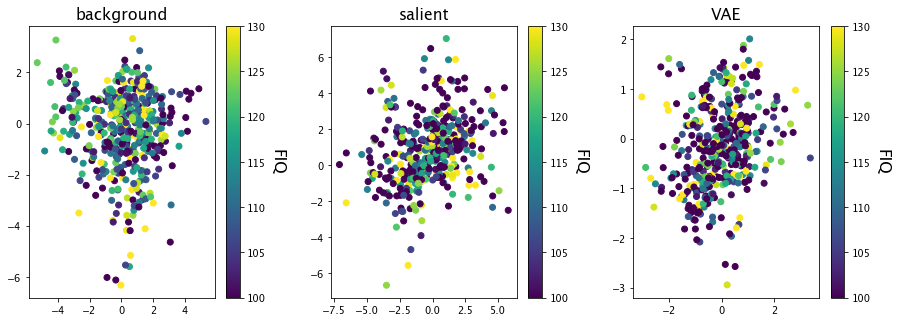

In [39]:
# Dots coliured by FIQ (Fluid IQ?)

fiq = df['FIQ'].values
fiq[abs(df['FIQ'].values)>200]=np.nan
plot_cscatter(fiq,clbl='FIQ',clim=(100,130),v=patients)

Text(0.5, 1.0, 'FIQ scores (all subjects)')

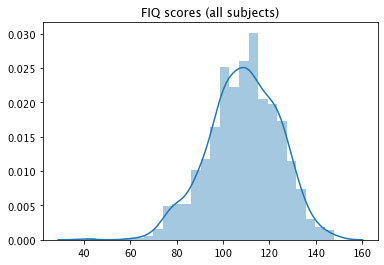

In [40]:
sns.distplot(df['FIQ'].values)
plt.title('FIQ scores (all subjects)')

Text(0.5, 1.0, 'DSM diagnosis categories')

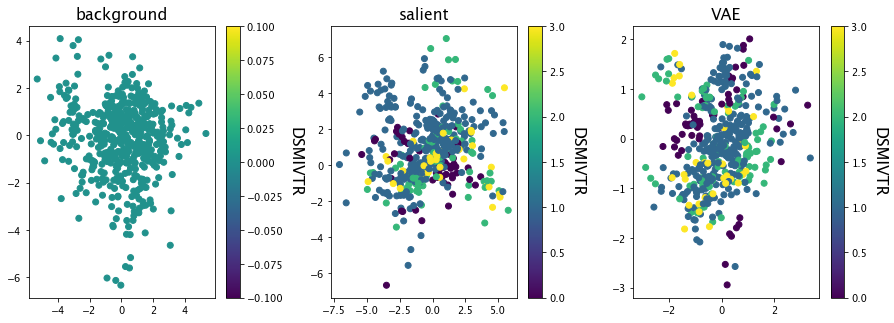

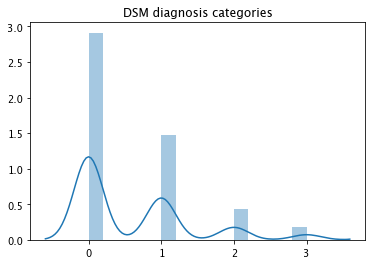

In [41]:
# DSM IV ASD categories

def numerize(val):
    try:
        return int(val)
    except:
        return 0
    
DSMIVTR = [numerize(val) for val in df['DSMIVTR'].values]
DSMIVTR = np.array(DSMIVTR)
plot_cscatter(DSMIVTR,clbl='DSMIVTR',clim=None,v=patients)

plt.figure()
sns.distplot(DSMIVTR)
plt.title('DSM diagnosis categories')

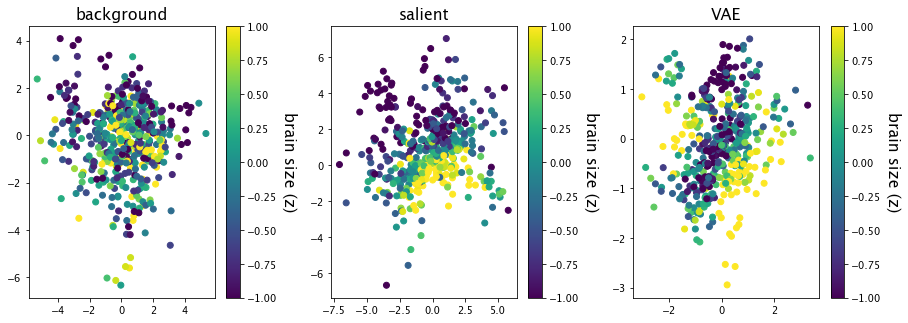

In [42]:
# Brain volume
#

head_size = np.array(np.reshape(ABIDE_data,(ABIDE_data.shape[0],-1))>.02).sum(axis=1)
head_sizez = (head_size-head_size.mean())/head_size.std()
plot_cscatter(head_sizez,clbl='brain size (z)',clim=(-1,1),v=controls)

In [43]:
df2 = pd.read_csv('/Users/aidasaglinskas/Desktop/BC-MRI-AE/CSVs/ABIDE_BIDS_PATHS.csv',index_col=0)
df2.index=np.arange(len(df2))
df2 = df2.iloc[np.array([df2['subID'].values[s] in df['BIDS_ID'].values for s in np.arange(len(df2))])]
df2.index=np.arange(len(df2))
df2 = df2.sort_values('subID')
df2.index=np.arange(len(df2))
print(f'{len(df2)}/{len(df)}')
n = len(df2)
df2.head()

assert len(df2)==len(df), 'different lenghts of CSVs'
assert all(np.array([df2['subID'].values[s]==df['BIDS_ID'].values[s] for s in np.arange(len(df))])),'mismatch between CSV orders'

982/982


In [44]:
def numerize(vec):
    #vec = center
    vec = np.array(vec)
    numVec = np.zeros(vec.shape[0])
    u = np.unique(vec)
    n_u = len(u)
    for i in range(n_u):
        numVec[vec==u[i]]=i

    return numVec

In [45]:
center = [line.split('/')[6] for line in df2['sub_path'].values]
scanner = [line.split('/')[8] for line in df2['sub_path'].values]

['achieva' 'allegra' 'discovery_mr750' 'intera'
 'magnetom_allegra_syngo_mr_a30' 'signa' 'triotim' 'verio']


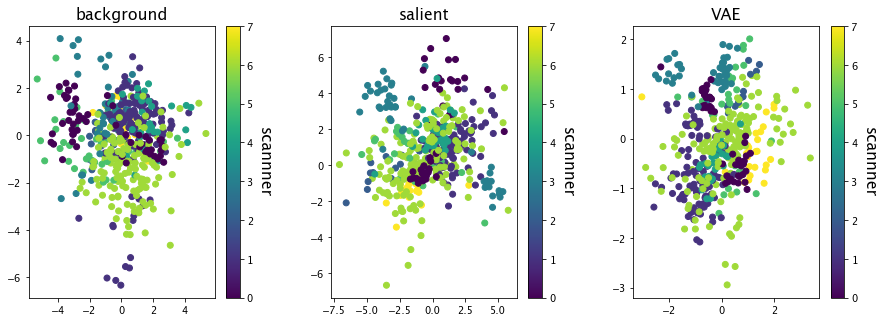

In [46]:
# Scanner type
plot_cscatter(numerize(scanner),clbl='scannner')
print(np.unique(scanner))

['caltech' 'kki' 'kul' 'mpg' 'nyu' 'ohsu' 'olin' 'pitt' 'sbl' 'sdsu' 'sjh'
 'stanford' 'ucla' 'um' 'usm' 'yale']


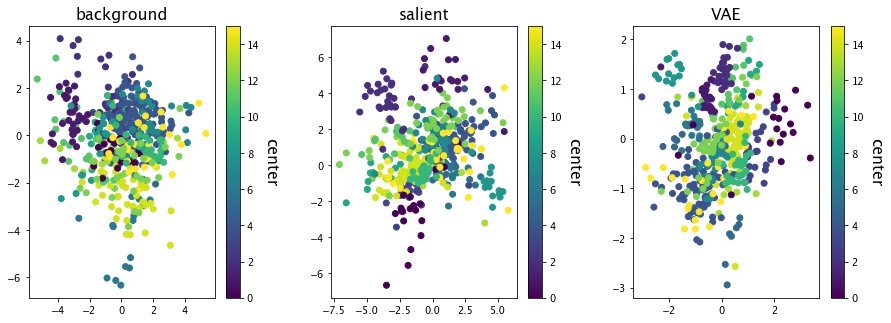

In [47]:
# Scanning center
plot_cscatter(numerize(center),clbl='center')
print(np.unique(center))

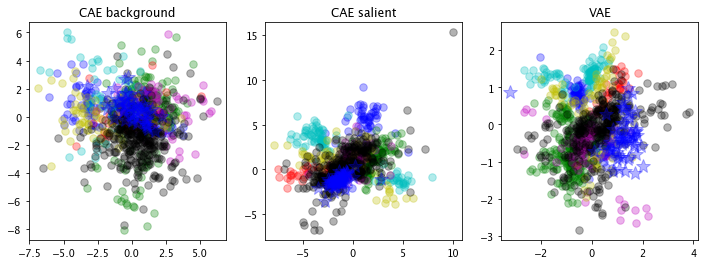

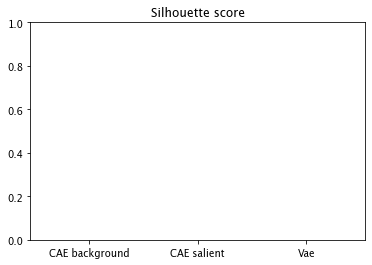

In [48]:
project_data(ABIDE_data,dxArr=numerize(scanner),lbls=np.unique(scanner),legend=False)

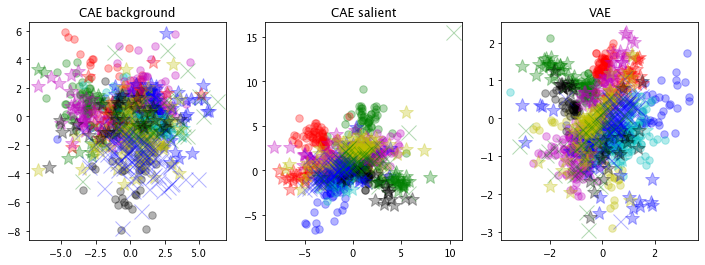

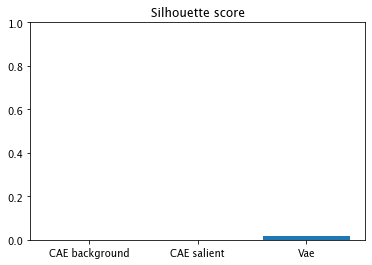

In [49]:
project_data(ABIDE_data,dxArr=numerize(center),lbls=np.unique(center),legend=False)

# RSA analyses

In [283]:
patients = df['Subject Type'].values=='PATIENT'
controls = df['Subject Type'].values=='CONTROL'
all_subs = patients+controls

space_bg_abide = np.array(encs[0].predict(ABIDE_data)[2])
space_sl_abide = np.array(encs[1].predict(ABIDE_data)[2])
space_vae_abide = np.array(encs[2].predict(ABIDE_data)[2])

# if space_bg_abide.shape[1] > 2:
#     space_bg_abide = dim_reduce(space_bg_abide)
#     space_sl_abide = dim_reduce(space_sl_abide)
#     space_vae_abide = dim_reduce(space_vae_abide)

In [284]:
#available_metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'jensenshannon', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']
dist_met = 'euclidean'
print(dist_met)

euclidean


In [285]:
def norm(mat):
    return (mat-mat.min())/(mat.max()-mat.min())

In [286]:
v = patients
RDM_age = norm(1-squareform(pdist(agesz[v][:,np.newaxis],metric=dist_met)))
RDM_gender  = norm(1-squareform(pdist(gender[v][:,np.newaxis],metric=dist_met)))
RDM_fiq  = norm(1-squareform(pdist(fiq[v][:,np.newaxis],metric=dist_met)))
RDM_dsm  = norm(1-squareform(pdist(DSMIVTR[v][:,np.newaxis],metric=dist_met)))
RDM_headsize  = norm(1-squareform(pdist(head_sizez[v][:,np.newaxis],metric=dist_met)))

In [287]:
modelRDMs = [RDM_age, RDM_gender, RDM_dsm, RDM_headsize]
modelRDM_titles = ['Age RDM','Gender RDM', 'DSM RDM', 'Brain vol RDM']

## RDM plots of Age, Gender, DSM and brain volume

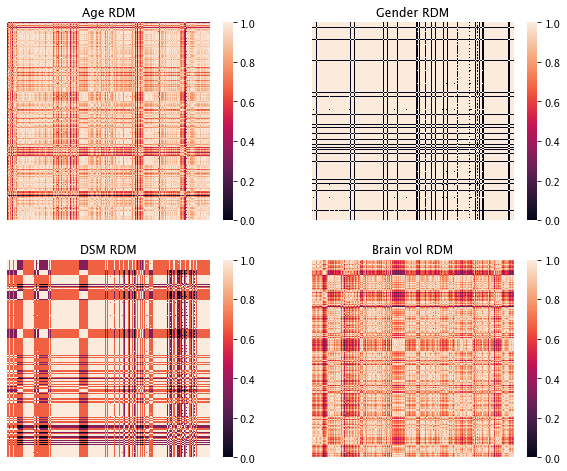

In [288]:
plt.figure(figsize=(10,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    sns.heatmap(modelRDMs[i])
    plt.xticks([]);plt.yticks([])
    plt.title(modelRDM_titles[i])

## Background, Salient and VAE RDM plots for ASD subjects (euclidean distance)

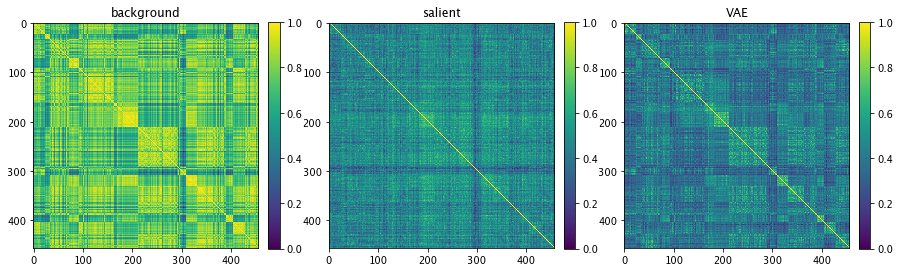

In [289]:
RDM_vae = norm(1-squareform(pdist(space_vae_abide[v], metric=dist_met)))
RDM_bg = norm(1-squareform(pdist(space_bg_abide[v], metric=dist_met)))
RDM_sl = norm(1-squareform(pdist(space_sl_abide[v], metric=dist_met)))

targ_RDMs = [RDM_vae,RDM_bg,RDM_sl]
targ_RDM_labels = ['VAE RDM','Background RDM','Salient RDM']


space_lbls = ['background','salient','VAE']
mats = [RDM_vae,RDM_bg,RDM_sl]
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    mat = mats[i]
    plt.imshow(mat)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(space_lbls[i])

In [290]:
def triu(inMat):
    '''return upper triangle values'''
    assert inMat.shape[0]==inMat.shape[1], 'mat not symetrical'
    n = inMat.shape[0]
    vec = inMat[np.triu_indices(n,1)]
    return vec

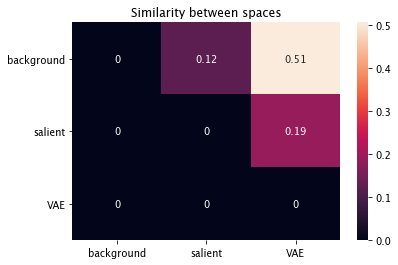

In [291]:
sim = np.corrcoef(np.array([triu(mat) for mat in mats]))
sim = np.triu(sim,k=1)
sns.heatmap(sim,annot=True);
plt.xticks(np.arange(sim.shape[0])+.5,labels=space_lbls);
plt.yticks(np.arange(sim.shape[0])+.5,labels=space_lbls,rotation=0);
plt.title('Similarity between spaces');

## RSA results (ASD patients)

In [292]:
def plot_groupBar(arr):
    colors = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
     (1.0, 0.4980392156862745, 0.054901960784313725),
     (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
     (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
     (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]
    for i in range(arr.shape[1]):
        x = i+1;
        plt.bar(i-.25,arr[0,i],color=colors[0],width=.45);
        plt.bar(i+.25,arr[1,i],color=colors[1],width=.45);

    plt.xticks(np.arange(arr.shape[1]),labels=targ_RDM_labels);
    plt.legend(['TD','ASD'])

[(456, 456), (456, 456), (456, 456), (456, 456)]
[(456, 456), (456, 456), (456, 456)]


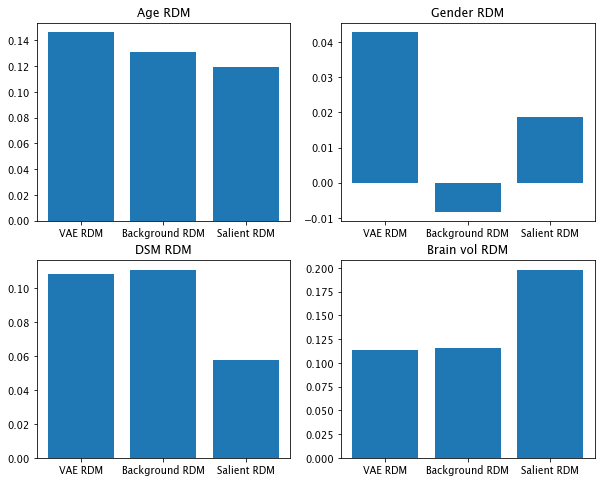

In [293]:
targ_RDMs = [RDM_vae,RDM_bg,RDM_sl]
targ_RDM_labels = ['VAE RDM','Background RDM','Salient RDM']

modelRDMs = [RDM_age, RDM_gender, RDM_dsm, RDM_headsize]
modelRDM_titles = ['Age RDM','Gender RDM', 'DSM RDM', 'Brain vol RDM']

print([m.shape for m in modelRDMs])
print([t.shape for t in targ_RDMs])

nTarg = len(targ_RDMs)
nModel = len(modelRDMs)
rsa_res = np.zeros((nTarg,nModel))

for t in range(nTarg):
    for m in range(nModel):
        rsa_res[t,m] = np.corrcoef(triu(targ_RDMs[t]),triu(modelRDMs[m]))[0,1]
        
plt.figure(figsize=(10,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.bar(np.arange(nTarg),rsa_res[:,i])
    plt.xticks(np.arange(nTarg),targ_RDM_labels)
    plt.title(modelRDM_titles[i])
    #plt.ylim(0,1)

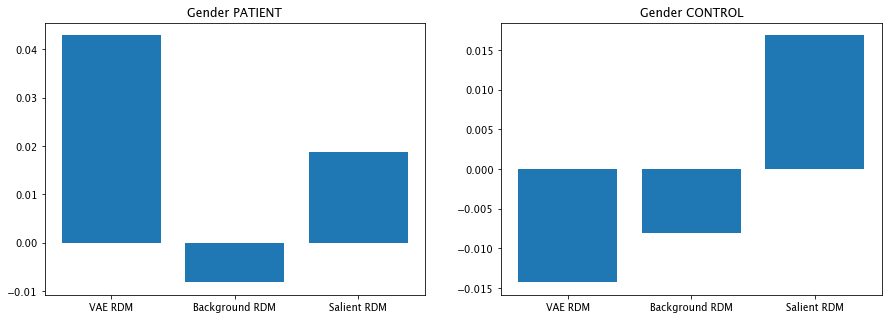

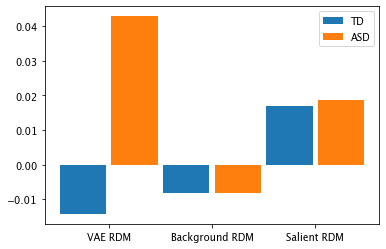

In [294]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
vv = np.array(df['Subject Type'].values=='CONTROL') #* ~np.isnan(df['FIQ'].values)
m = triu(norm(1-squareform(pdist(df['Sex'].values[vv][:,np.newaxis],metric=dist_met))))
T = np.array([1-triu(norm(squareform(pdist(space[vv], metric=dist_met)))) for space in [space_vae_abide,space_bg_abide,space_sl_abide]])
arr1 = np.array([np.corrcoef(m,T[i,:])[0,1] for i in range(3)])
plt.bar([0,1,2],arr1)
plt.xticks(np.arange(nTarg),targ_RDM_labels)
plt.title('Gender CONTROL')
#plt.ylim(0,1)

plt.subplot(1,2,1)
vv = np.array(df['Subject Type'].values=='PATIENT') #* ~np.isnan(df['FIQ'].values)
m = triu(norm(1-squareform(pdist(df['Sex'].values[vv][:,np.newaxis],metric=dist_met))))
T = np.array([1-triu(norm(squareform(pdist(space[vv], metric=dist_met)))) for space in [space_vae_abide,space_bg_abide,space_sl_abide]])
arr2 = np.array([np.corrcoef(m,T[i,:])[0,1] for i in range(3)])
plt.bar([0,1,2],arr2)
plt.xticks(np.arange(nTarg),targ_RDM_labels)
plt.title('Gender PATIENT')
#plt.ylim(0,1)

plt.figure()
plot_groupBar(np.vstack((arr1,arr2)))

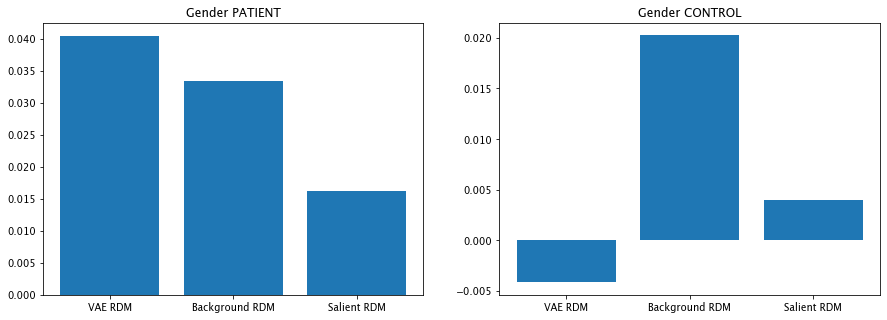

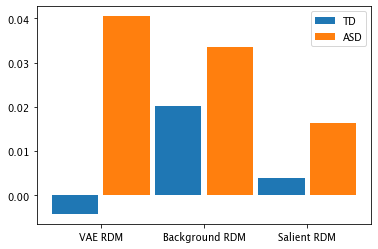

In [295]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
vv = np.array(df['Subject Type'].values=='CONTROL') * ~np.isnan(df['FIQ'].values)
m = triu(norm(1-squareform(pdist(df['FIQ'].values[vv][:,np.newaxis],metric=dist_met))))
T = np.array([1-triu(norm(squareform(pdist(space[vv], metric=dist_met)))) for space in [space_vae_abide,space_bg_abide,space_sl_abide]])
arr1 = np.array([np.corrcoef(m,T[i,:])[0,1] for i in range(3)])
plt.bar([0,1,2],arr1)
plt.xticks(np.arange(nTarg),targ_RDM_labels)
plt.title('Gender CONTROL')
#plt.ylim(0,1)

plt.subplot(1,2,1)
vv = np.array(df['Subject Type'].values=='PATIENT') * ~np.isnan(df['FIQ'].values)
m = triu(norm(1-squareform(pdist(df['FIQ'].values[vv][:,np.newaxis],metric=dist_met))))
T = np.array([1-triu(norm(squareform(pdist(space[vv], metric=dist_met)))) for space in [space_vae_abide,space_bg_abide,space_sl_abide]])
arr2 = np.array([np.corrcoef(m,T[i,:])[0,1] for i in range(3)])
plt.bar([0,1,2],arr2)
plt.xticks(np.arange(nTarg),targ_RDM_labels)
plt.title('Gender PATIENT')
#plt.ylim(0,1)

plt.figure()
plot_groupBar(np.vstack((arr1,arr2)))

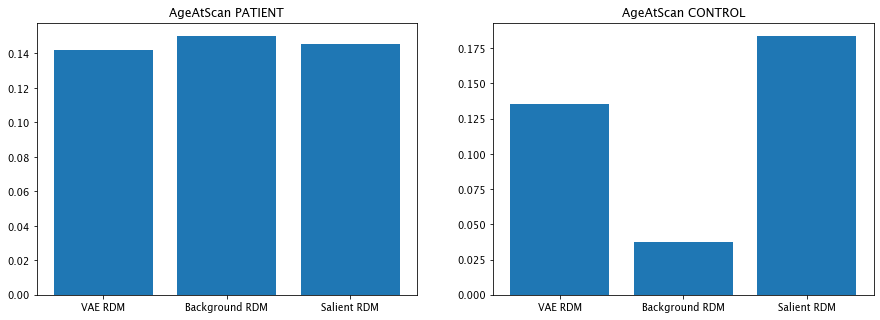

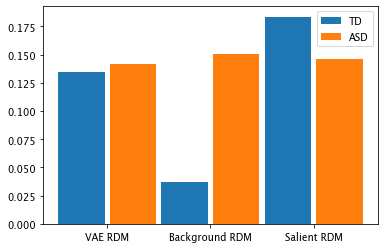

In [296]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
vv = np.array(df['Subject Type'].values=='CONTROL') * ~np.isnan(df['FIQ'].values)
m = triu(norm(1-squareform(pdist(df['AgeAtScan'].values[vv][:,np.newaxis],metric=dist_met))))
T = np.array([1-triu(norm(squareform(pdist(space[vv], metric=dist_met)))) for space in [space_vae_abide,space_bg_abide,space_sl_abide]])
arr1 = np.array([np.corrcoef(m,T[i,:])[0,1] for i in range(3)])
plt.bar([0,1,2],arr1)
plt.xticks(np.arange(nTarg),targ_RDM_labels)
plt.title('AgeAtScan CONTROL')
#plt.ylim(0,1)

plt.subplot(1,2,1)
vv = np.array(df['Subject Type'].values=='PATIENT') * ~np.isnan(df['FIQ'].values)
m = triu(norm(1-squareform(pdist(df['AgeAtScan'].values[vv][:,np.newaxis],metric=dist_met))))
T = np.array([1-triu(norm(squareform(pdist(space[vv], metric=dist_met)))) for space in [space_vae_abide,space_bg_abide,space_sl_abide]])
arr2 = np.array([np.corrcoef(m,T[i,:])[0,1] for i in range(3)])
plt.bar([0,1,2],arr2)
plt.xticks(np.arange(nTarg),targ_RDM_labels)
plt.title('AgeAtScan PATIENT')
#plt.ylim(0,1)

plt.figure()
plot_groupBar(np.vstack((arr1,arr2)))

Text(0.5, 1.0, 'DSM category')

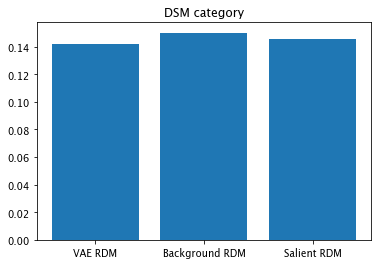

In [297]:
#vv = np.array(df['Subject Type'].values=='PATIENT') * ~np.isnan(df['FIQ'].values)
vv = all_subs
RDM_dsm  = norm(1-squareform(pdist(DSMIVTR[vv][:,np.newaxis],metric=dist_met)))
m = triu(RDM_dsm)
T = np.array([1-triu(norm(squareform(pdist(space[vv], metric=dist_met)))) for space in [space_vae_abide,space_bg_abide,space_sl_abide]])
plt.bar([0,1,2],arr2)
plt.xticks(np.arange(nTarg),targ_RDM_labels)
plt.title('DSM category')

In [298]:
patients = df['Subject Type'].values=='PATIENT'
controls = df['Subject Type'].values=='CONTROL'
all_subs = patients+controls

space_bg_abide = np.array(encs[0].predict(ABIDE_data)[2])
space_sl_abide = np.array(encs[1].predict(ABIDE_data)[2])
space_vae_abide = np.array(encs[2].predict(ABIDE_data)[2])

In [299]:
bv = dict()

In [300]:
bv['center'] = np.array(center)
bv['scanner'] = np.array(scanner)
bv['head_size'] = np.array(head_size )
bv['head_sizez'] = np.array(head_sizez)
bv['DSMIVTR'] = np.array(DSMIVTR)
bv['fiq'] = np.array(fiq)
bv['gender'] = np.array(gender)
bv['agesz'] = np.array(agesz)
bv['diag'] = np.array(controls*1)+np.array(patients*2)

In [301]:
def tabulate(vec):
    u = np.unique(vec)
    n = len(u)
    tab = np.zeros((n,2))

    for i in range(n):
        #tab[i,0] = u[i]
        tab[i,0] = sum(vec==u[i])
        tab[i,1] = sum(vec==u[i])/len(vec)
        
        tab[i,1] = tab[i,1].round(3)
        tab[i,0] = int(tab[i,0])

    f = pd.DataFrame(columns=['name','count','perc'])
    f['name']=u;f['count']=tab[:,0];f['perc']=tab[:,1]
    f = f.sort_values('count',ascending=False)
    f.head()
    return f

In [302]:
#from imblearn.under_sampling import TomekLinkstl = TomekLinks(return_indices=True, ratio='majority')X_tl, y_tl, id_tl = tl.fit_sample(X, y)

In [303]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import ttest_ind


from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

In [304]:
#3BalancedRandomForestClassifier().fit(np.random.rand(10,2),np.repeat(1,11))

In [305]:
from sklearn.linear_model import LogisticRegression

In [306]:
((df['Sex'].values==2)*(df['DxGroup'].values==1)).sum()

55

In [307]:
def fit_clf(y,vv):
    #spaces = [space_vae_abide,space_bg_abide,space_sl_abide]
    spaces = [space_vae_abide,space_bg_abide,space_sl_abide,np.hstack((space_bg_abide,space_sl_abide))]
    accs,ses,arrs = list(),list(),list()
    for x in spaces:
        x = x[vv]
        #clf = KNeighborsClassifier(n_neighbors=15)
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=None, solver='lbfgs', max_iter=1000, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
        clf.fit(x,y)
        res = cross_validate(clf, x, y, cv=3)['test_score']
        
        arrs.append(res)
        acc = res.mean()    
        se = res.std()
        accs.append(acc)
        ses.append(se)

    plt.bar(np.arange(len(spaces)),accs);
    plt.errorbar(np.arange(len(spaces)),accs,ses,fmt='r.')
    plt.xticks(np.arange(len(spaces)),labels=['vae','bg','sl','bg+sl']);
    
    balanced=True
    if balanced:
        plt.plot(np.arange(-.5,len(spaces)+.5),np.repeat(1/len(np.unique(y)),len(spaces)+1),'k-.',alpha=.3)
    else:    
        plt.plot(np.arange(-.5,len(spaces)+.5),np.repeat(tabulate(y)['perc'].values.max(),len(spaces)+1),'k-.',alpha=.3)

In [308]:
space_bg_abide = np.array(encs[0].predict(ABIDE_data)[2])
space_sl_abide = np.array(encs[1].predict(ABIDE_data)[2])
space_vae_abide = np.array(encs[2].predict(ABIDE_data)[2])

In [309]:
print(bv.keys())

dict_keys(['center', 'scanner', 'head_size', 'head_sizez', 'DSMIVTR', 'fiq', 'gender', 'agesz', 'diag'])


Text(0.5, 1.0, 'DX: Children')

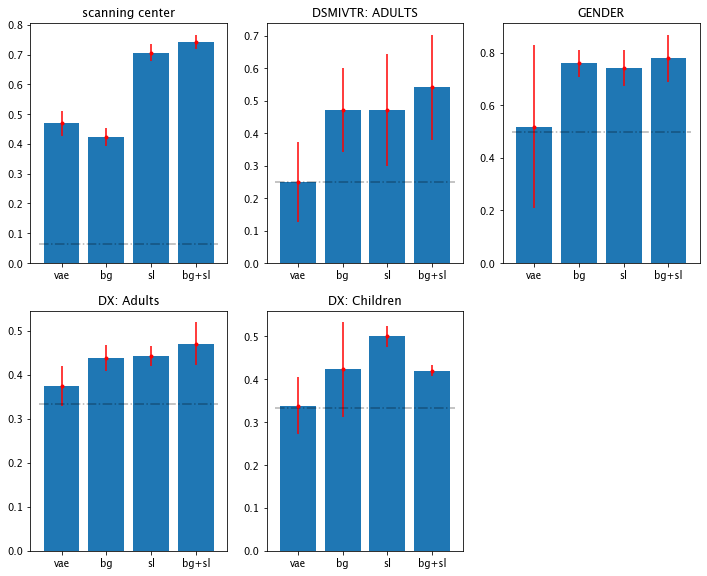

In [310]:
plt.figure(figsize=(12,15))
plt.subplot(3,3,1);vv = patients;y = numerize(bv['center'])[vv];fit_clf(y,vv);plt.title('scanning center')
plt.subplot(3,3,2);vv = patients*df['AgeAtScan'].values > 18;y = numerize(bv['DSMIVTR'])[vv];fit_clf(y,vv);plt.title('DSMIVTR: ADULTS')

plt.subplot(3,3,3);vv = patients*df['AgeAtScan'].values > 28;y = numerize(bv['gender'])[vv];fit_clf(y,vv);plt.title('GENDER')


plt.subplot(3,3,4);vv = (all_subs*df['AgeAtScan'].values > 25)*df['Sex'].values!=3;y = numerize(bv['diag'])[vv];fit_clf(y,vv);plt.title('DX: Adults')
plt.subplot(3,3,5);vv = (all_subs*df['AgeAtScan'].values < 12)*df['Sex'].values==2;y = numerize(bv['diag'])[vv];fit_clf(y,vv);plt.title('DX: Children')

In [311]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression

def fit_reg(y,vv):
    spaces = [space_vae_abide,space_bg_abide,space_sl_abide,np.hstack((space_bg_abide,space_sl_abide))]
    accs,ses,arrs = list(),list(),list()
    for x in spaces:
        x = x[vv]
        clf = LinearRegression()
        mse = ((clf.fit(x,y).predict(x)-y)**2).mean()
        accs.append(1-mse/((y-y.mean())**2).mean())
    plt.bar(np.arange(len(spaces)),accs);
    plt.xticks(np.arange(len(spaces)),labels=['vae','bg','sl','both']);

dict_keys(['center', 'scanner', 'head_size', 'head_sizez', 'DSMIVTR', 'fiq', 'gender', 'agesz', 'diag'])


(0.1, 1)

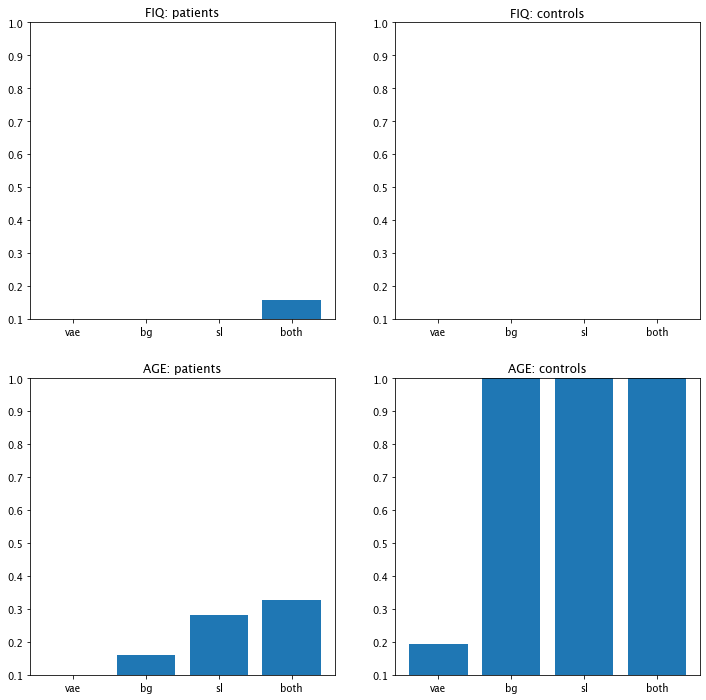

In [312]:
plt.figure(figsize=(12,12))
print(bv.keys())

plt.subplot(2,2,1);vv = (patients*~np.isnan(df['FIQ'].values))*(df['AgeAtScan'].values<20);y = df['FIQ'].values[vv];fit_reg(y,vv);plt.title('FIQ: patients')
plt.ylim(.1,1)
plt.subplot(2,2,2);vv = controls*~np.isnan(df['FIQ'].values);y = df['FIQ'].values[vv];fit_reg(y,vv);plt.title('FIQ: controls')
plt.ylim(.1,1)

plt.subplot(2,2,3);vv = (patients*df['AgeAtScan'].values < 12);y = df['AgeAtScan'].values[vv];fit_reg(y,vv);plt.title('AGE: patients')
plt.ylim(.1,1)
plt.subplot(2,2,4);vv = (controls*df['AgeAtScan'].values > 18)*df['Sex'].values==2;y = df['AgeAtScan'].values[vv];fit_reg(y,vv);plt.title('AGE: controls')
plt.ylim(.1,1)


#plt.subplot(2,2,3);vv = np.array(df['Subject Type'].values=='CONTROL')*~np.isnan(df['FIQ'].values);y = df['FIQ'].values[vv];fit_reg(y,vv);plt.title('FIQ')
#plt.subplot(2,2,4);vv = ~np.isnan(df['FIQ'].values);y = df['FIQ'].values[vv];fit_reg(y,vv);plt.title('FIQ')
#plt.subplot(2,2,3);vv = controls;y = df['AgeAtScan'].values[vv];fit_reg(y,vv);plt.title('AGE')
#plt.subplot(2,2,4);vv = controls;y = df['AgeAtScan'].values[vv];fit_reg(y,vv);plt.title('AGE')